In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from matplotlib import cm
from skimage.segmentation import chan_vese
from scipy import ndimage
from skimage.morphology import watershed

In [2]:
MIN = 0
MAX = 2 ** 16 - 1

In [3]:
# import all images per sequence, return images
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

In [4]:
imgs = import_sequences()

In [5]:
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]
NUM_IMAGES = len(imgs[0])

In [6]:
# show an image inline
def show(img, s=True):
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

In [7]:
# segment original image using thresholding
def segment(original):
    img = np.zeros_like(original)
    cv2.threshold(original, dst=img, thresh=np.median(original)*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
    img1 = np.zeros_like(original)
    cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
    img2 = np.zeros_like(original)
    cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
    return img2

In [8]:
# segment the image using Chan-Vese Level Set Method, then processing steps
def segment_CV(img):
    img_cv = chan_vese(img, mu=5, lambda1=1, lambda2=1, tol=1e-3,
                dt=3, init_level_set="checkerboard",
                extended_output=True)[0]
    vals = np.unique(img_cv, return_counts=True)[1]
    if vals[0] < vals[1]:
        img = np.logical_not(img_cv).astype('uint16') * MAX
    else:
        img = img_cv.astype('uint16') * MAX
    pts = points(img)
    mask = np.zeros((6,6))
    mask[1:-1,1:-1] = np.ones((4,4)) * MAX
    delete = {}
    for (i,j) in pts:
        if (i,j) in delete:
            continue
        if i-1 < 0 or i+5 > NROWS-1 or j-1 < 0 or j+5 > NCOLS-1:
            continue
        if np.array_equal(mask, img[i-1:i+5,j-1:j+5]):
            for m in range(4):
                for n in range(4):
                    delete[(i+m,j+n)] = None
    for pt in delete:
        del pts[pt]
    pts, _ = flush_border_cells(pts, create_img(pts))
    for i in range(2):
        pts = dilate(pts)
    for i in range(2):
        pts = erode(pts)
    img = create_img(pts).astype('uint16')
    imgb = np.zeros_like(img)
    imgb = cv2.GaussianBlur(img, dst=imgb, ksize=(0,0), sigmaX=4)
    imgb = cv2.threshold(imgb, dst=imgb, thresh=40000, maxval=MAX, type=cv2.THRESH_BINARY)[1]
    return imgb

In [9]:
# get white points of an image, return dict of coord tuples
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

In [10]:
# flush all cells that touch the border of the image
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    while len(to_check) > 0:
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
    new = img - border_img
    return points(new), new.astype('uint16')

In [11]:
# create an image from points
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new.astype('uint16')

In [12]:
# binary erosion of points with 3x3 filter
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

In [13]:
# binary dialtion of points with 3x3 filter
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

In [14]:
# check coords within image bounds
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

In [329]:
def segment_CLAHE(img, show_img=False):
    clahe = cv2.createCLAHE(clipLimit=80.0, tileGridSize=(25,25))
    cl1 = clahe.apply(img)

    hist = cv2.calcHist([cl1],[0],None,[257],[0,MAX])
    from_max = hist[np.argmax(hist):]
    for intensity, num in enumerate(from_max[:-1]):
        if from_max[intensity+1] >= from_max[intensity]:
            for i in range(30):
                if intensity + i >= len(from_max):
                    break
                if from_max[intensity + i] < intensity - 250:
                    break
            else:
                break

    final = (intensity + np.argmax(hist)) * 255
    seg = np.zeros_like(cl1)
    cv2.threshold(cl1, dst=seg, thresh=final, maxval=MAX, type=cv2.THRESH_BINARY)
    opens = np.zeros_like(seg)
    elem = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5,5))
    cv2.morphologyEx(seg, dst=opens, op=cv2.MORPH_OPEN, kernel=elem)
    if show_img:
        show(img)
        show(opens)
        plt.figure(figsize=(15,15))
        plt.hist(cl1.ravel(),255)
        plt.axvline(x=final, color='r')
        plt.show()
    return opens

In [310]:
# from points and labels create a coloured image
def colour_label_image(pts_labels, show_img=True, max=None):
    cmap = cm.get_cmap('hsv').copy()
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    if max == None:
        norm_new = plt.Normalize(new_img.min(), new_img.max())
    else:
        norm_new = plt.Normalize(new_img.min(), max)
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show_img:
        show(rgba_img)
    return rgba_img

In [258]:
# plot scatter of centroids over the colour labelled image
def plt_rgb_img_scatter(centroids, pts_labels):
    rgb_img = colour_label_image(pts_labels, False)
    plt.figure(figsize=(15,15))
    plt.imshow(rgb_img)
    for (x, y) in centroids.keys():
        plt.scatter(y, x, c='white', marker='.')
    plt.show()

In [259]:
# get cell contours (outlines) from points
def contours(pts):
    dilated2_pts = dilate(pts)
    sub = {}
    for pt, label in dilated2_pts.items():
        if pt not in pts:
            sub[pt] = label
    return sub

In [260]:
# check that points are not colliding for rebuilding seperation
def no_collision(pt, label, existing_pts):
    for (i,j) in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
        point = (pt[0]+i,pt[1]+j)
        if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    for i in range(-1, 2):
        for j in range(-1, 2):
            point = (pt[0]+i,pt[1]+j)
            if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    return True

In [261]:
# rebuild segmented image so no cells are touching
def rebuild(img, show=True, flush=True):
    if flush:
        pts, img = flush_border_cells(points(img), img)
    else:
        pts = points(img)
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((7,7)), labels = img, min_distance=12)
    coords = {tuple(c): i for i, c in enumerate(coords)}
    
    dilated2_pts = coords.copy()
    while 1:
        base = dilated2_pts.copy()
        dilated1_pts = base.copy()
        for pt, label in base.items():
            pt1 = (pt[0],pt[1]-1)
            if pt1 in dilated1_pts:
                pass
            elif no_collision(pt1, label, dilated1_pts) and pt1 in pts:
                dilated1_pts[pt1] = label
            
            pt2 = (pt[0], pt[1]+1)
            if pt2 in dilated1_pts:
                pass
            elif no_collision(pt2, label, dilated1_pts) and pt2 in pts:
                dilated1_pts[pt2] = label
       
        dilated2_pts = dilated1_pts.copy()
        for pt, label in dilated1_pts.items():
            pt1 = (pt[0]-1,pt[1])
            if pt1 in dilated2_pts:
                pass
            elif no_collision(pt1, label, dilated2_pts) and pt1 in pts:
                dilated2_pts[pt1] = label
            
            pt2 = (pt[0]+1, pt[1])
            if pt2 in dilated2_pts:
                pass
            elif no_collision(pt2, label, dilated2_pts) and pt2 in pts:
                dilated2_pts[pt2] = label
        if base == dilated2_pts:
            break
    if show:
        colour_label_image(dilated2_pts)
    return dilated2_pts

In [270]:
# find average size of cells in the image
def avg_cell_size(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(pts) / len(labels)

In [271]:
# count the number of cells in the image
def cell_count(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(labels)

In [365]:
# use watershed after Chan-Vese to get best results
def watershed_seg(img, min_dist=20):
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = min_dist, labels = img)
    mask = np.zeros(distance.shape, dtype = bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    ws_labels = watershed(-distance, markers, mask = img)
    ws_pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ws_labels[i,j] == 0:
                continue
            ws_pts[(i,j)] = ws_labels[i,j]-1
    return ws_pts

In [285]:
# get centroids from points
def centroids(pts):
    labels = {}
    for (x,y), label in pts.items():
        if label not in labels:
            labels[label] = {'x': [x], 'y': [y]}
            continue
        labels[label]['x'].append(x)
        labels[label]['y'].append(y)
    centres = {}
    for label, data in labels.items():
        centres[int(sum(data['x'])/len(data['x'])), 
                int(sum(data['y'])/len(data['y']))] = label
    return centres

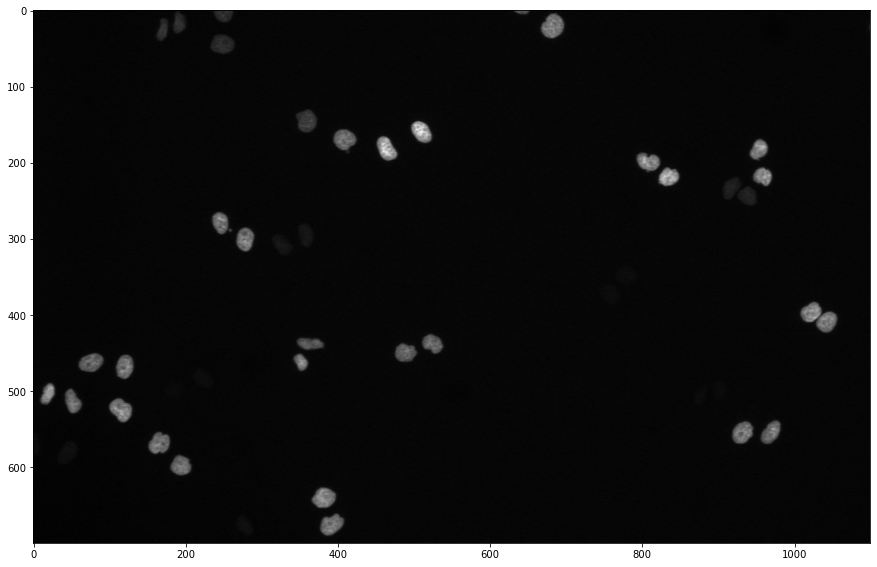

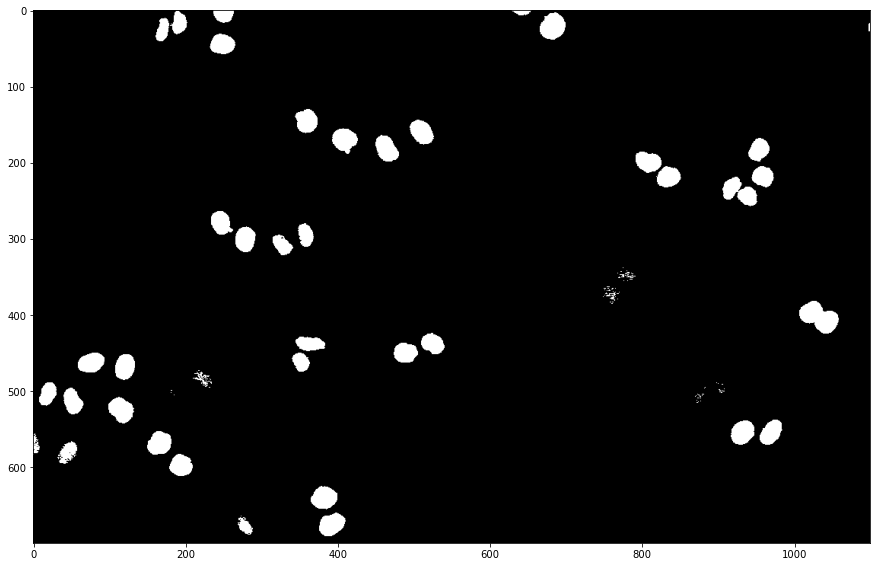

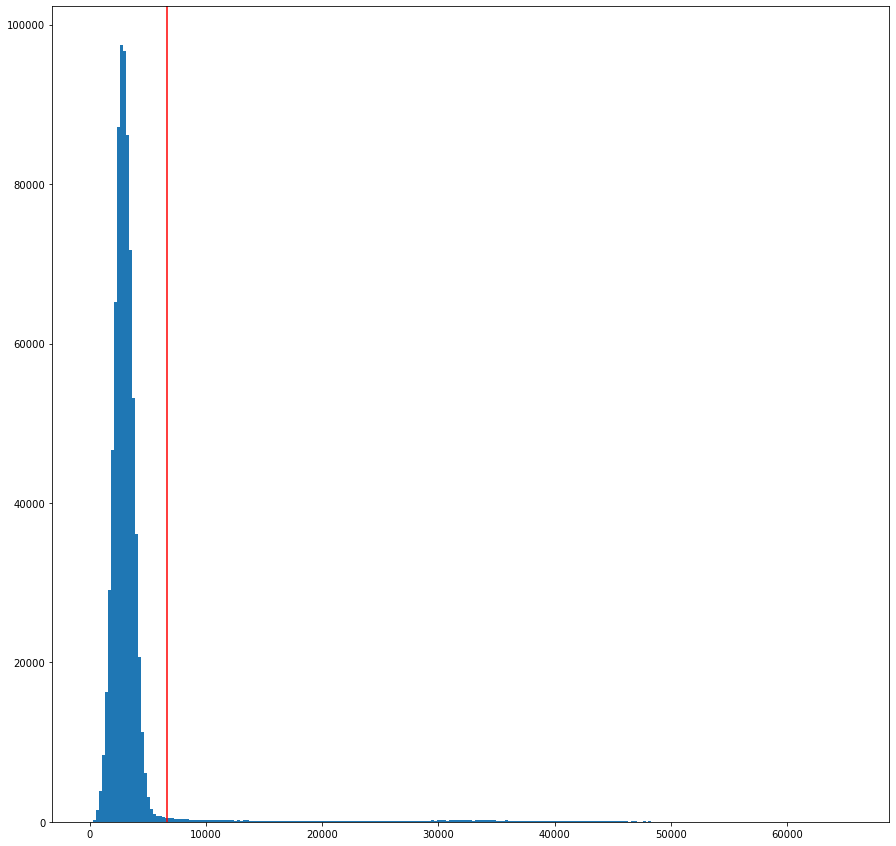

In [227]:
_ = segment_CLAHE(imgs[0][0], True)

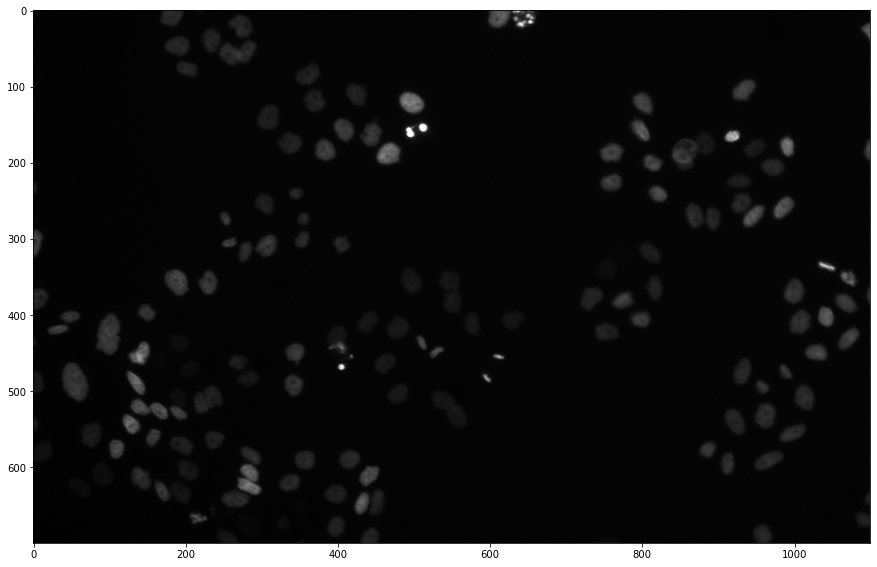

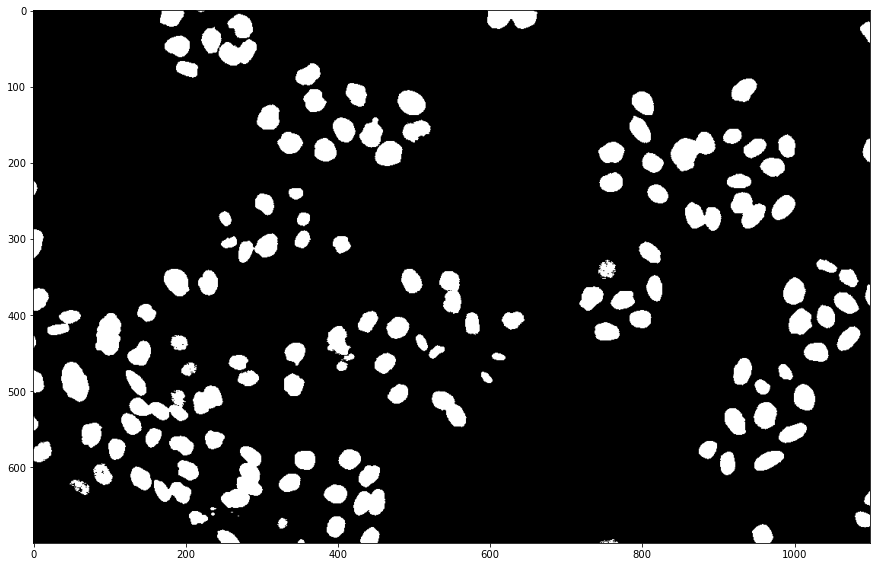

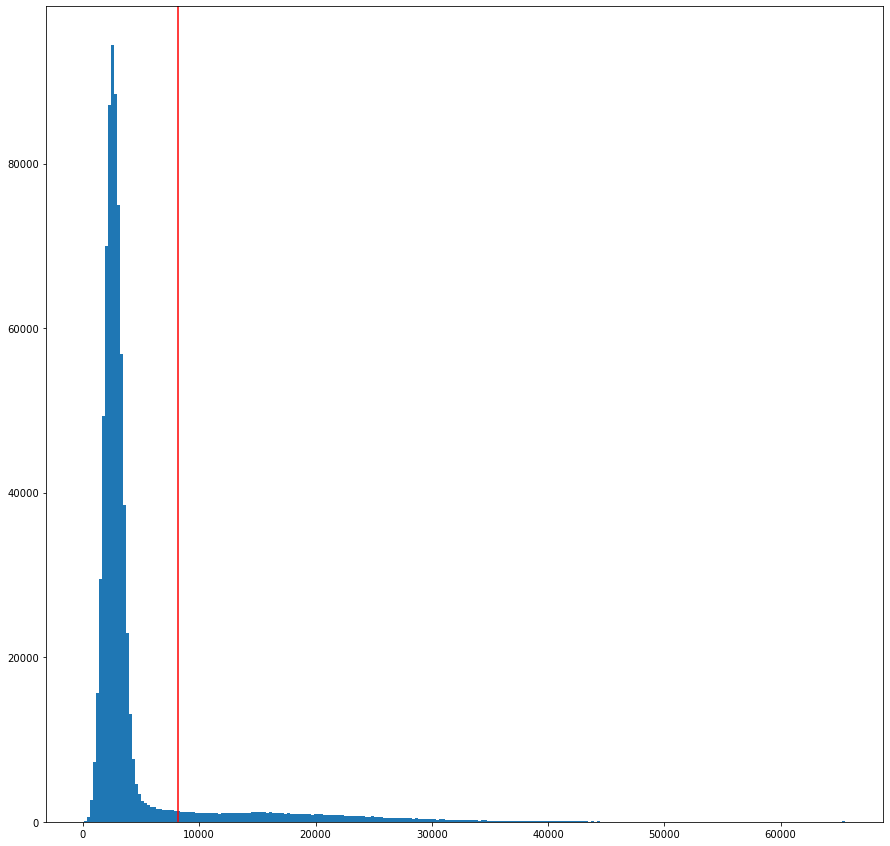

In [229]:
_ = segment_CLAHE(imgs[0][-1], True)

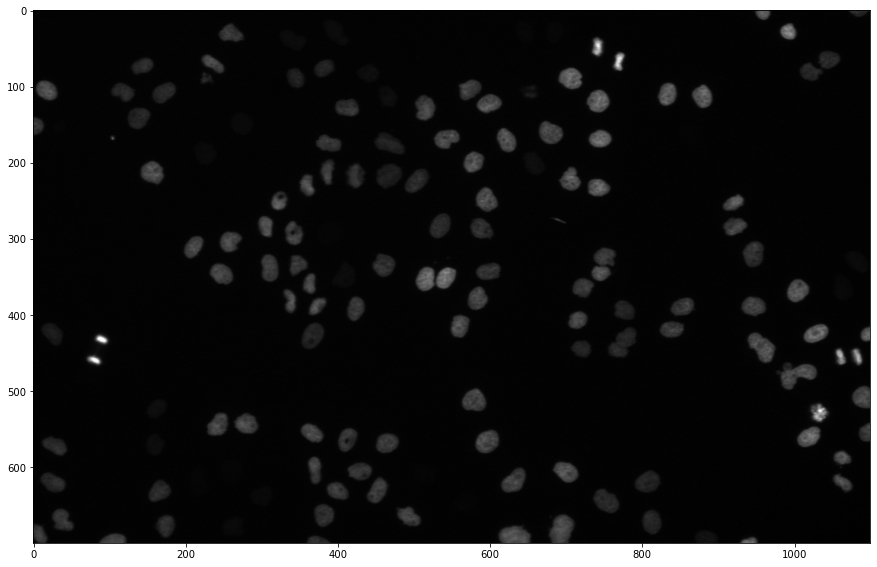

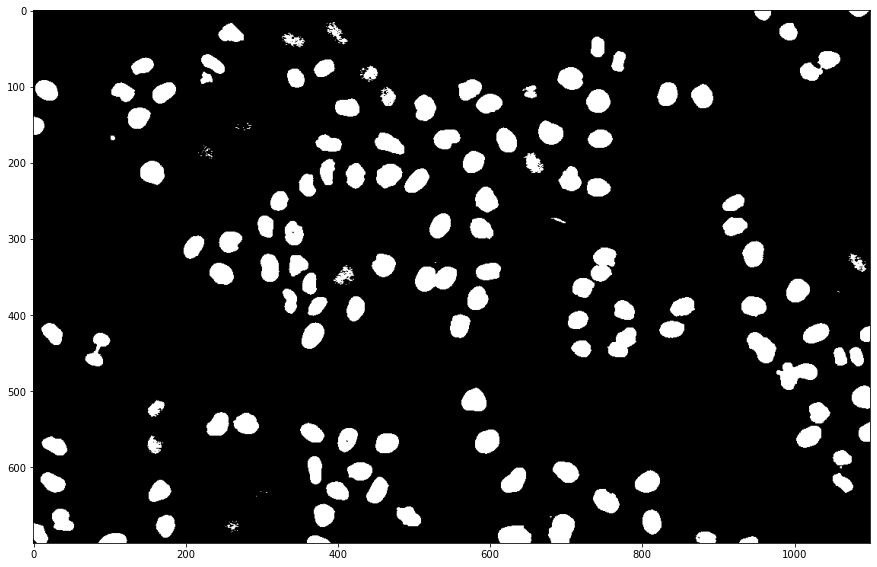

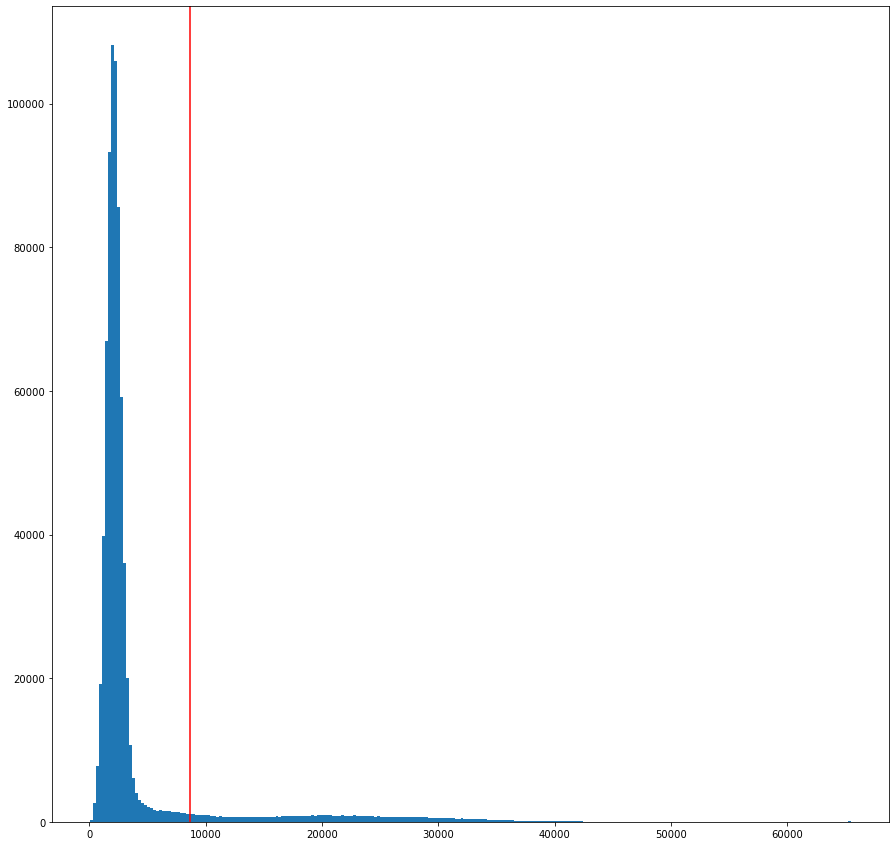

In [230]:
_ = segment_CLAHE(imgs[1][0], True)

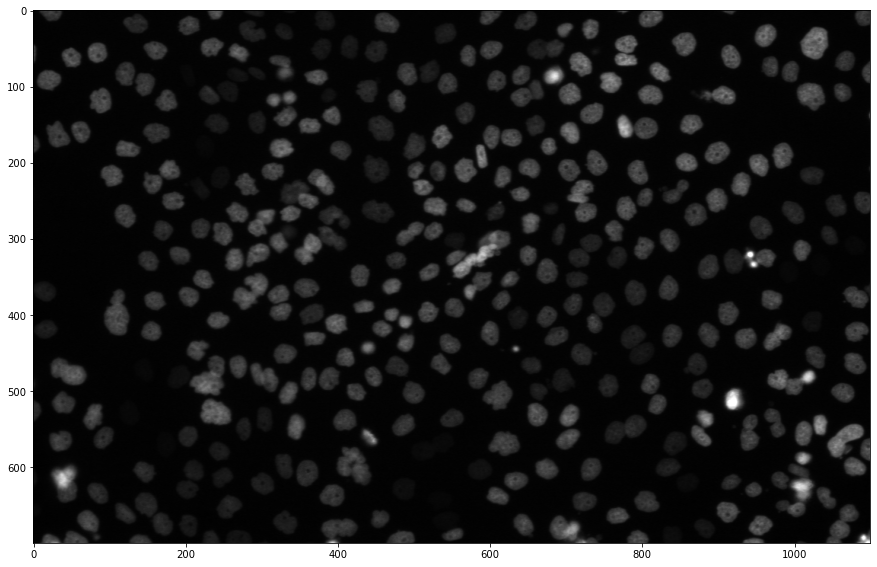

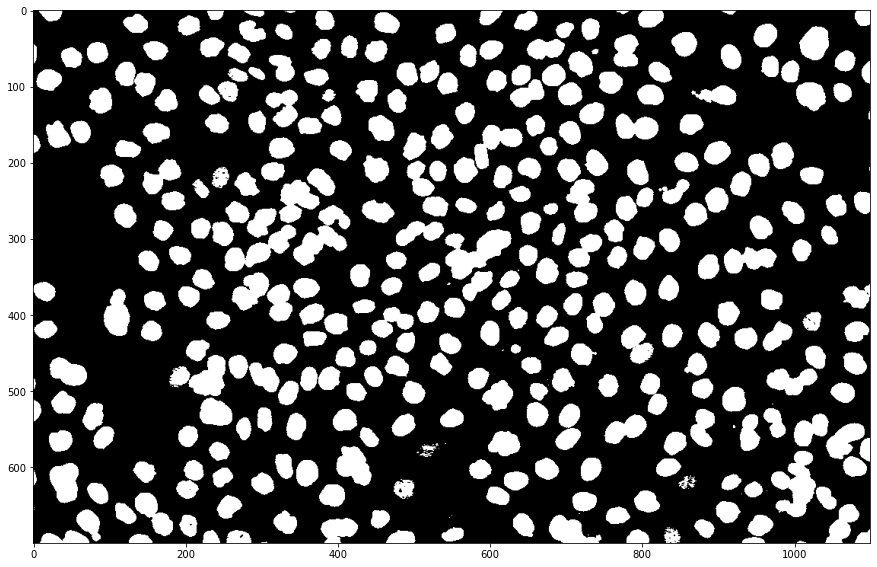

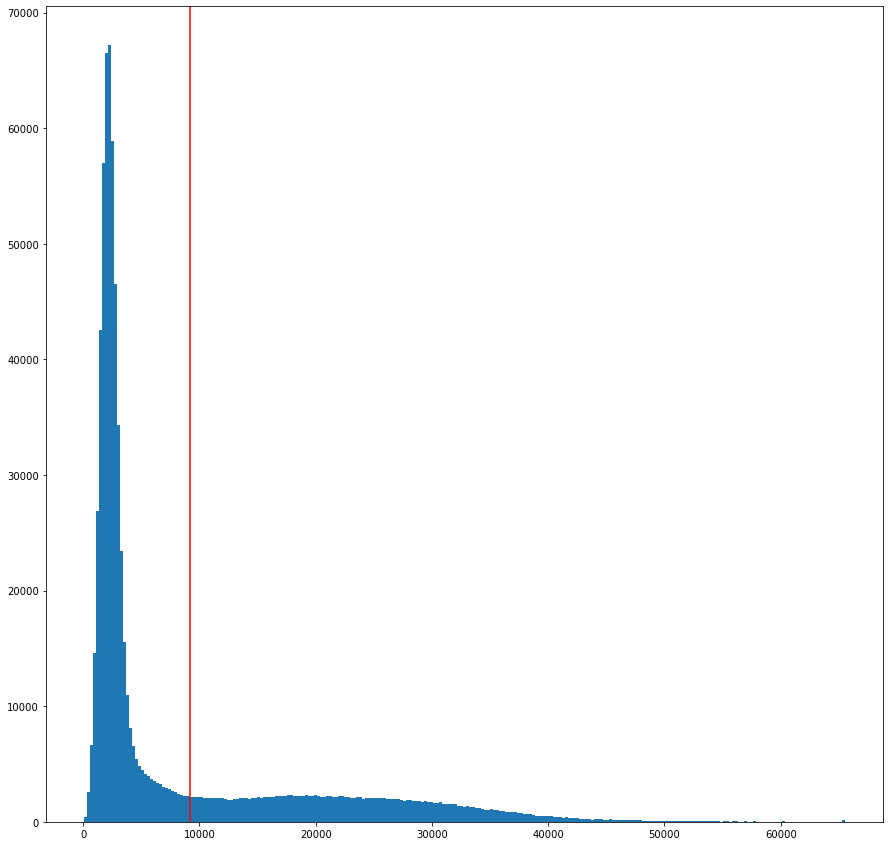

In [231]:
_ = segment_CLAHE(imgs[1][-1], True)

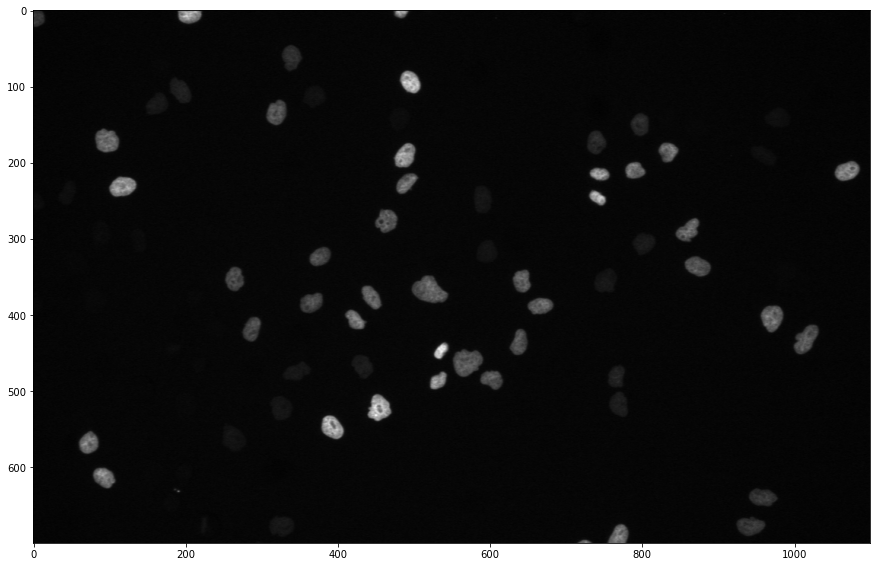

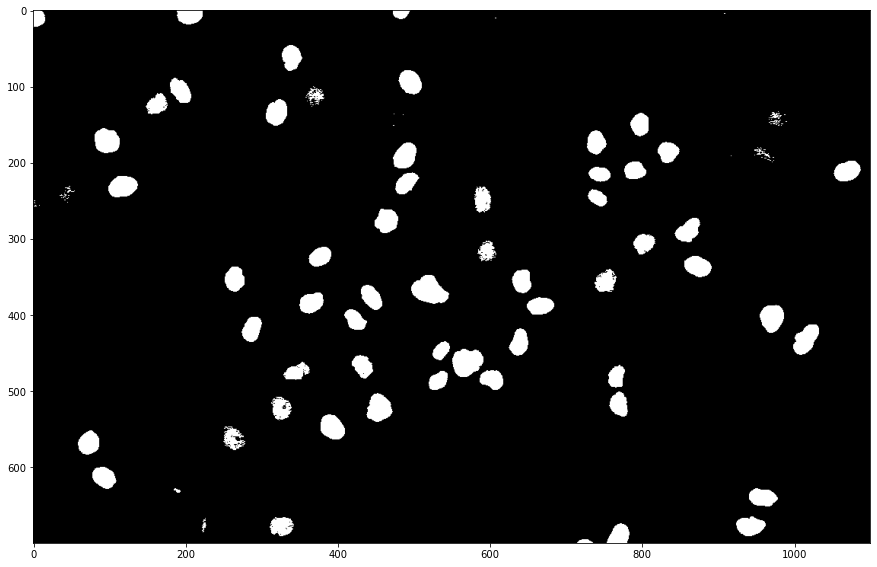

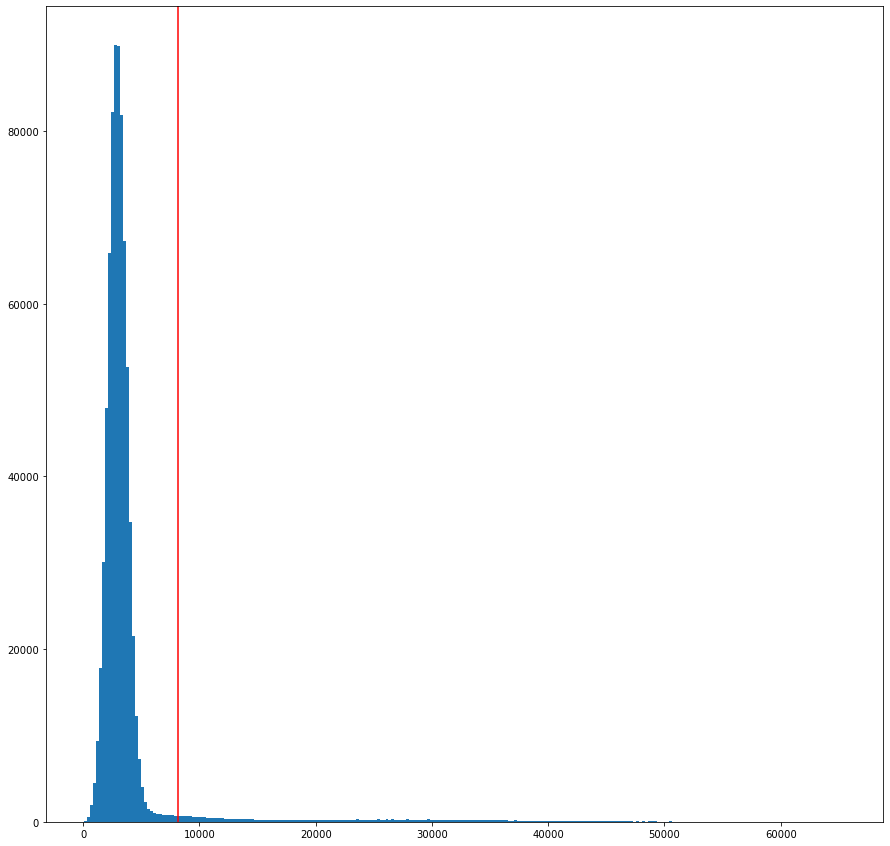

In [232]:
_ = segment_CLAHE(imgs[2][0], True)

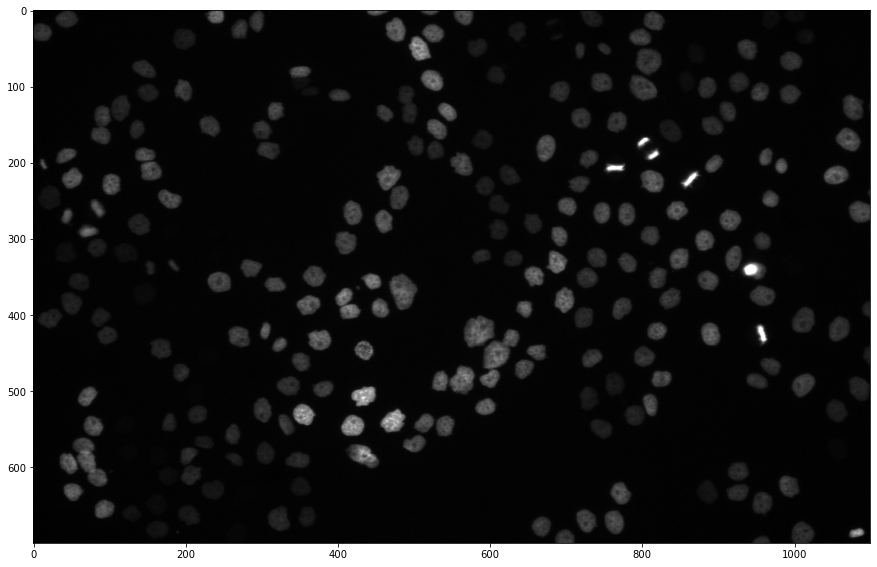

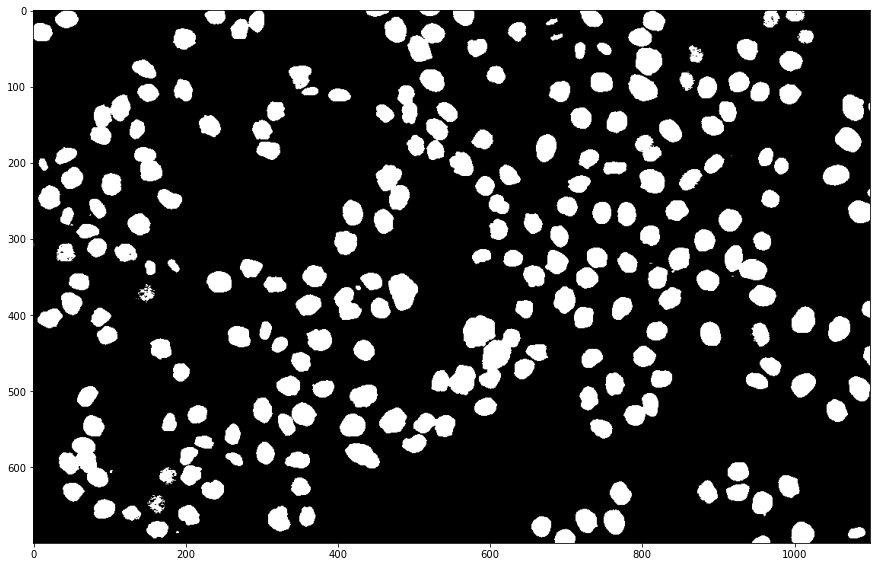

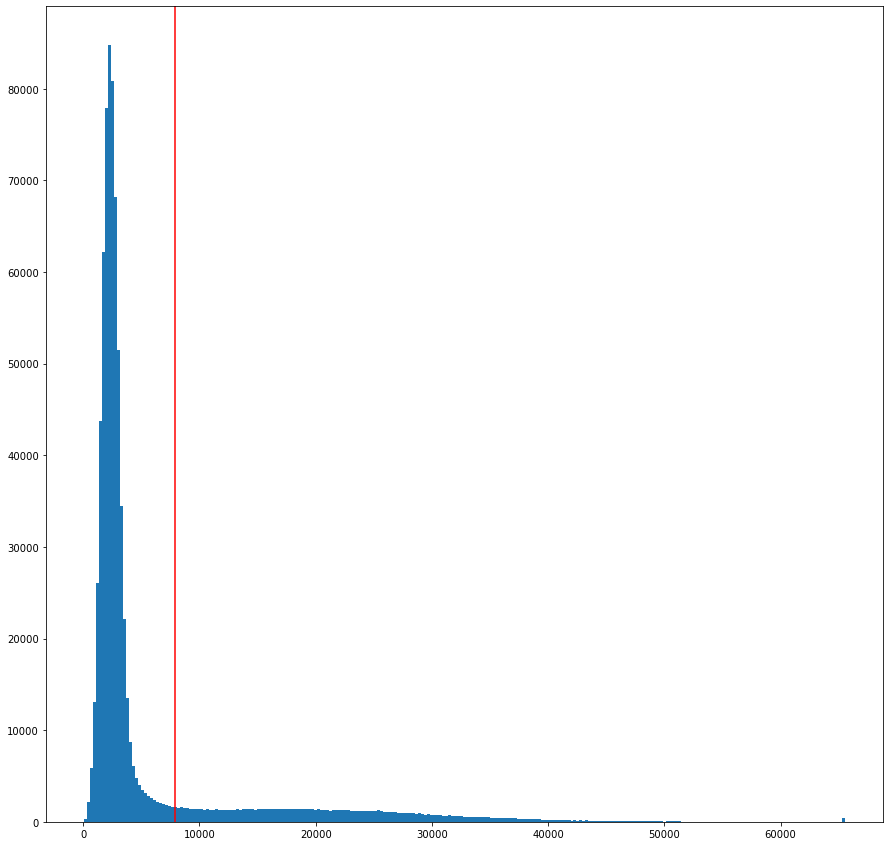

In [233]:
_ = segment_CLAHE(imgs[2][-1], True)

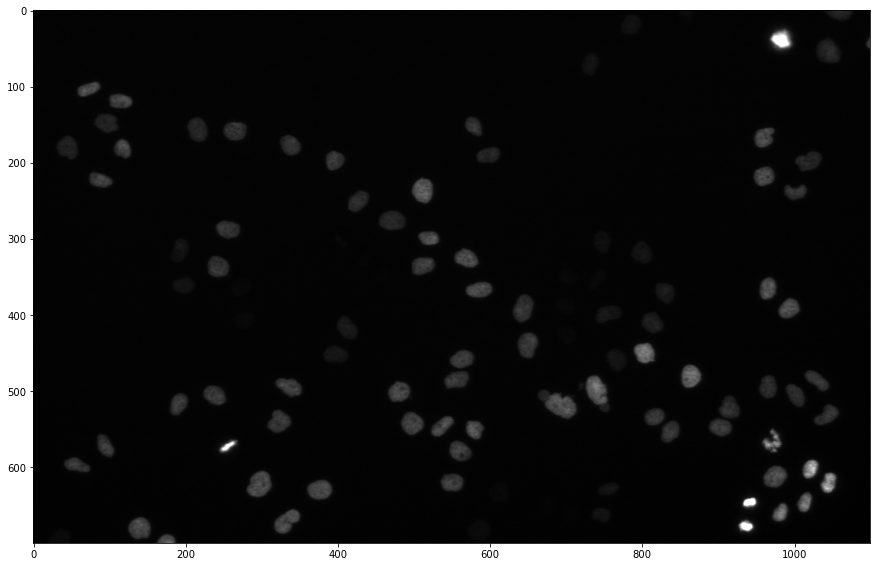

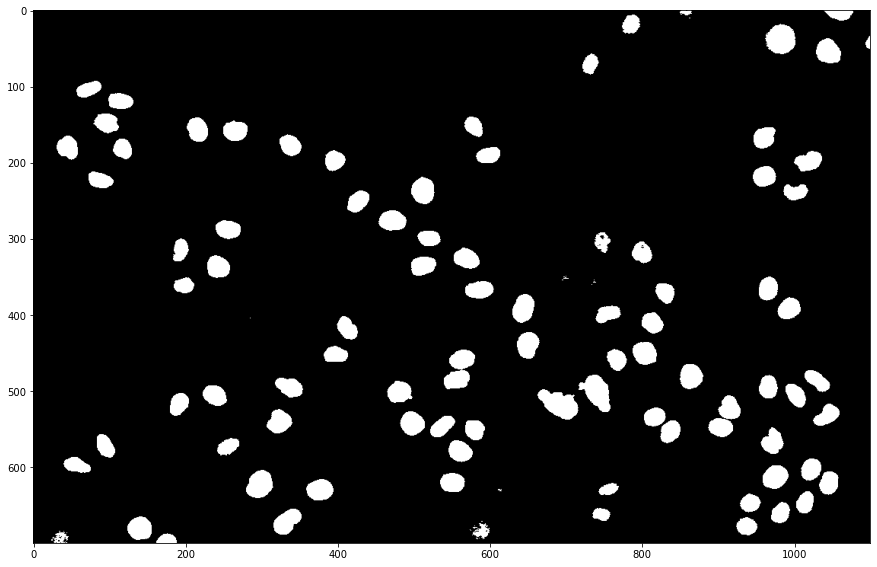

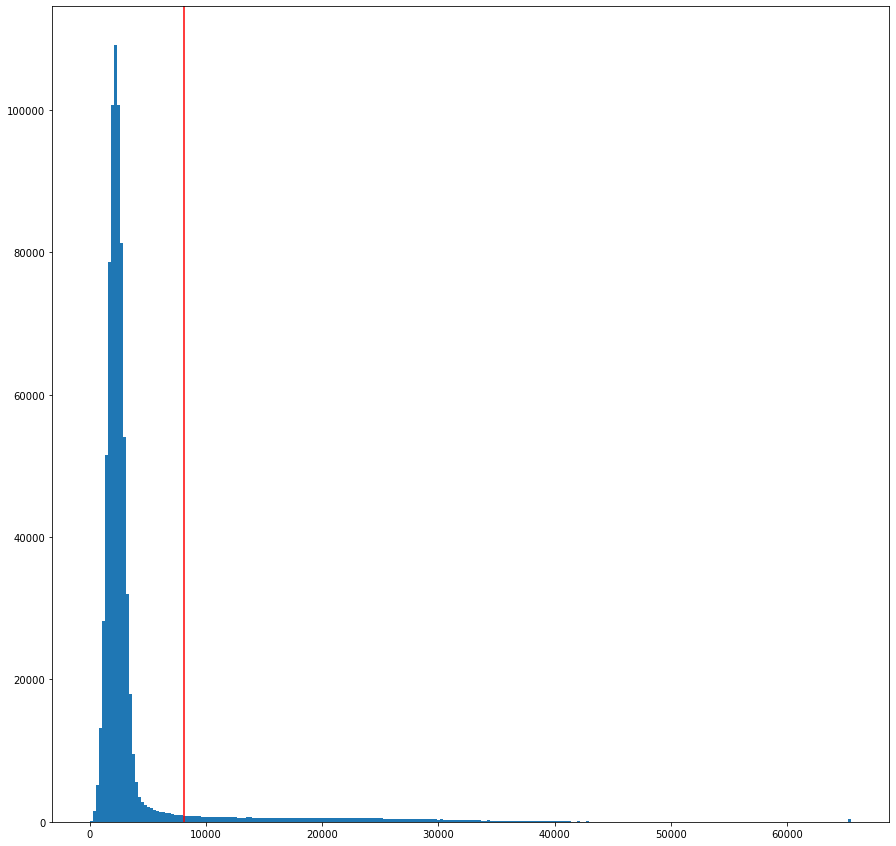

In [234]:
_ = segment_CLAHE(imgs[3][0], True)

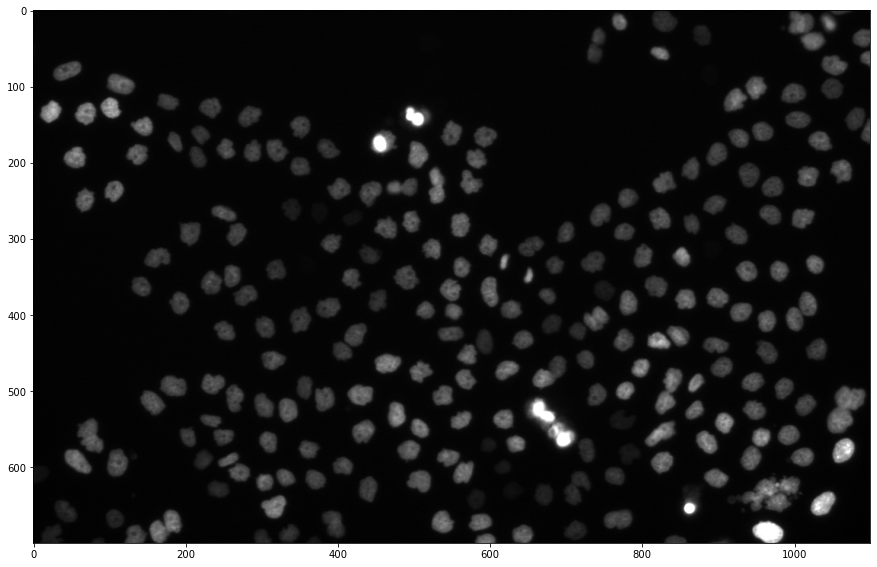

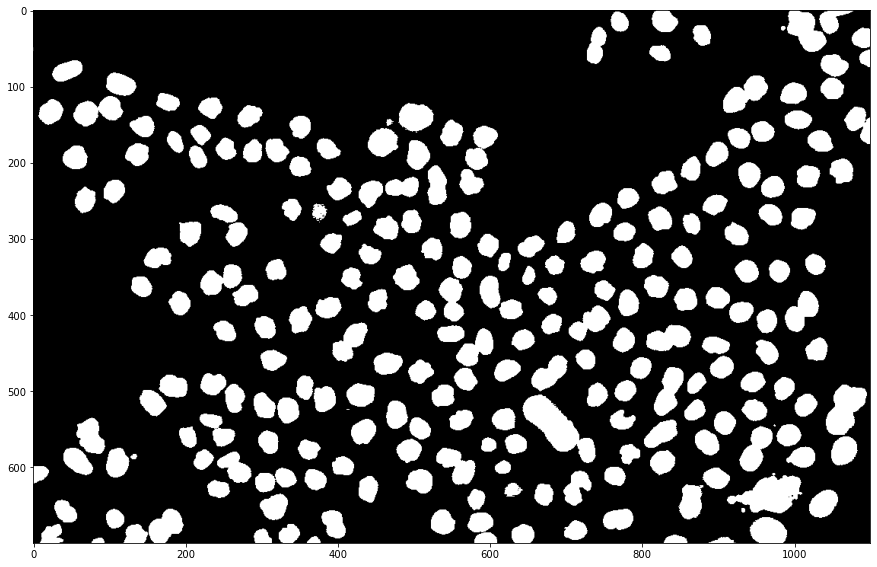

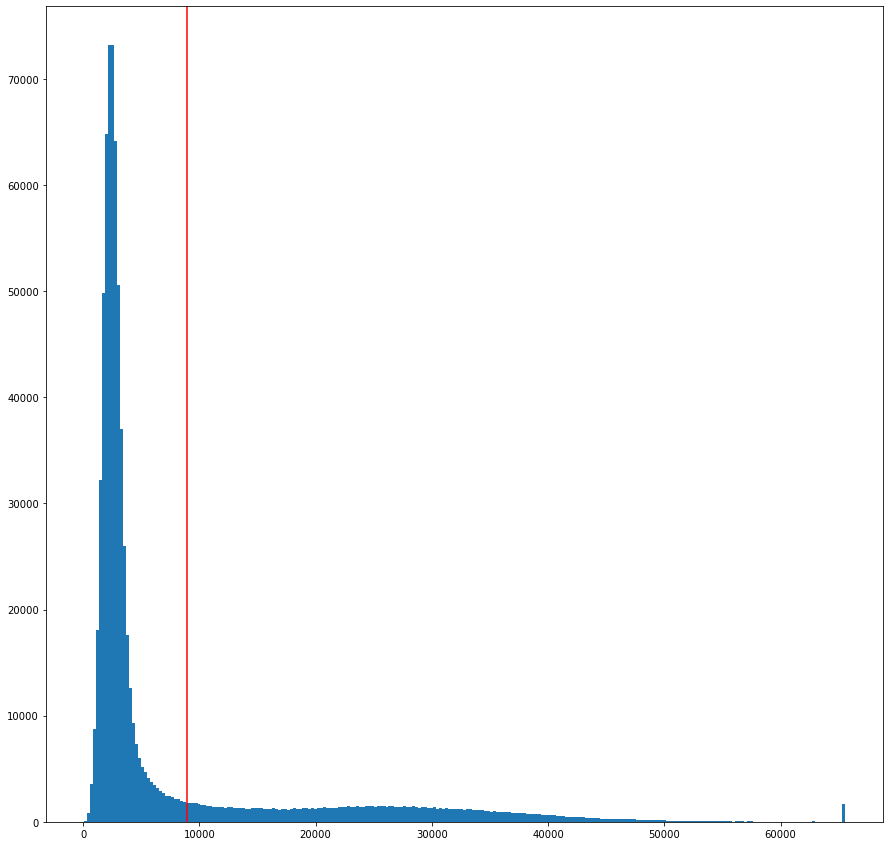

In [235]:
_ = segment_CLAHE(imgs[3][-1], True)

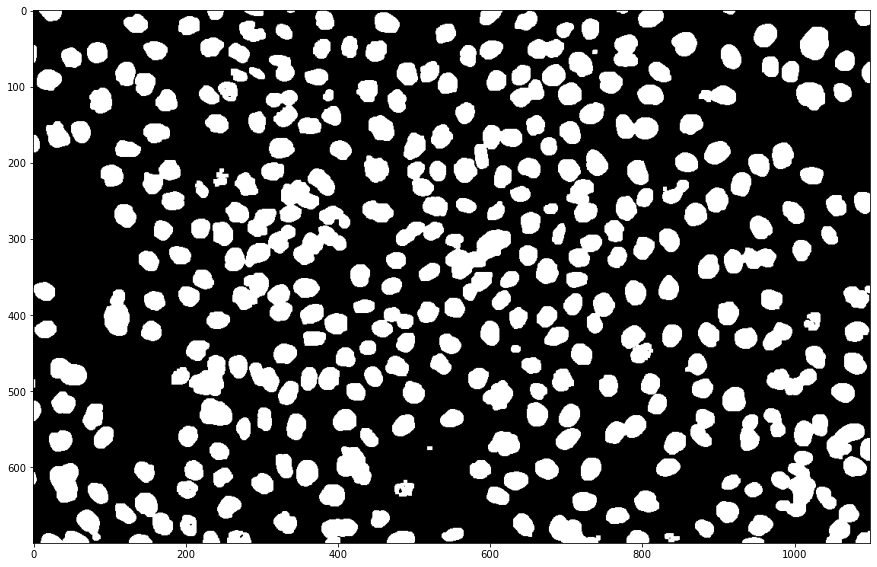

In [358]:
seg = segment_CLAHE(imgs[1][-1], False)
show(seg)

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


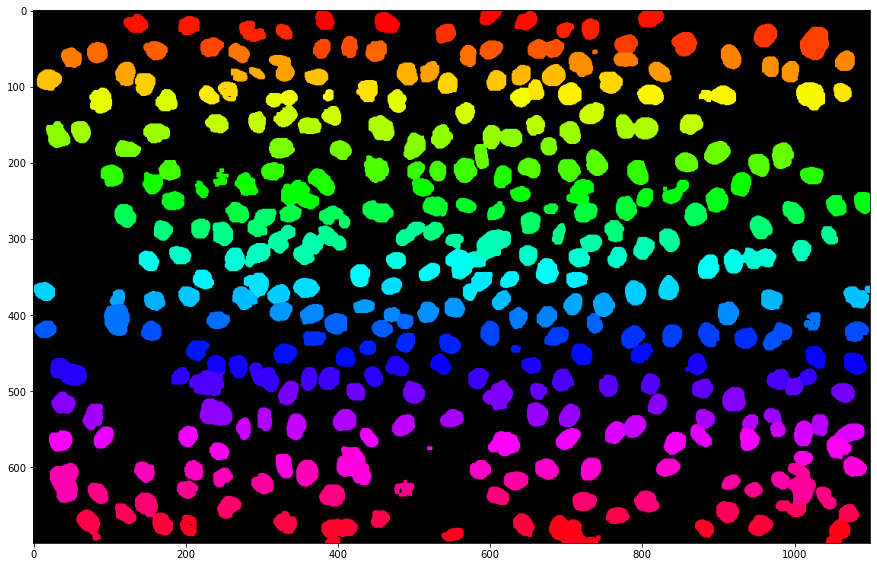

In [359]:
distance = ndimage.distance_transform_edt(seg)
coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = 17, labels = seg)
mask = np.zeros(distance.shape, dtype = bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
ws_labels = watershed(-distance, markers, mask = seg)
ws_pts = {}
for i in range(seg.shape[0]):
    for j in range(seg.shape[1]):
        if ws_labels[i,j] == 0:
            continue
        ws_pts[(i,j)] = ws_labels[i,j]-1
_ = colour_label_image(ws_pts)

In [367]:
cents0 = centroids(ws_pts)
def mix_labels(pts):
    cents = centroids(pts)
    len(cents)
    shuffled = np.arange(0, len(cents))
    np.random.shuffle(shuffled)
    swap_labels = {}
    for i, label in enumerate(cents.values()):
        swap_labels[label] = shuffled[i]
    pts = {}
    for pt, label in ws_pts.items():
        pts[pt] = swap_labels[label]
    return pts

In [361]:
pts = mix_labels(ws_pts)

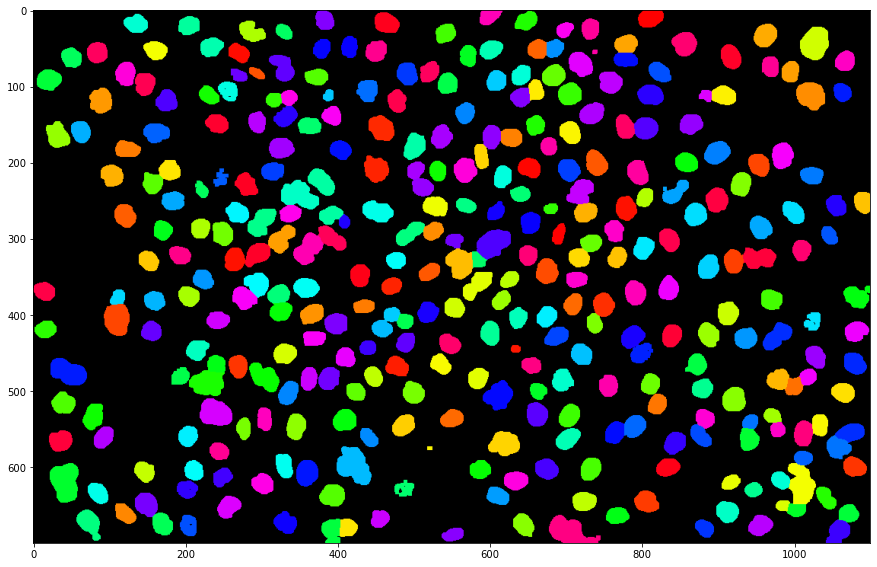

In [362]:
_ = colour_label_image(pts)

In [370]:
def segment(img):
    thresh = segment_CLAHE(img)
    ws_pts = watershed_seg(thresh, min_dist=17)
    return mix_labels(ws_pts)


In [372]:
pts = segment(imgs[1][-1])

C:\Users\moate\anaconda3\envs\COMP9517\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


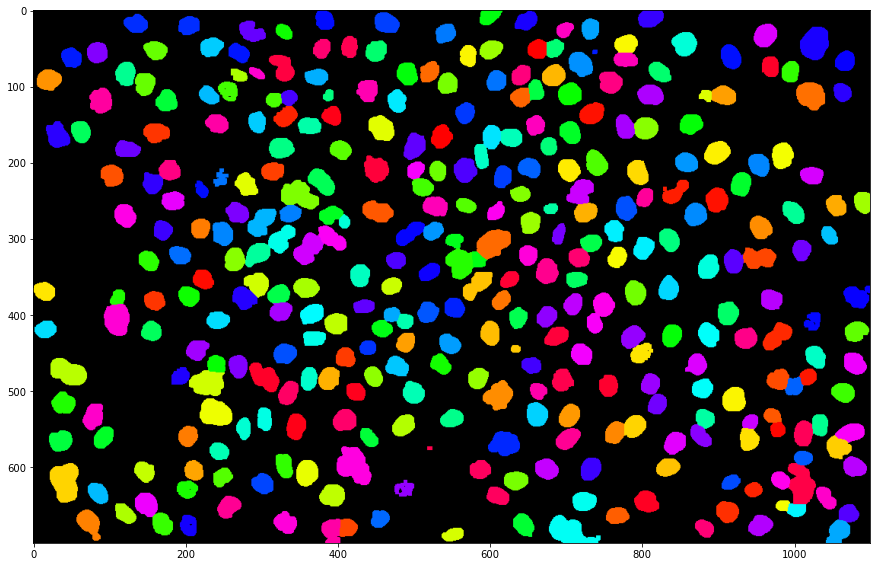

In [374]:
_ = colour_label_image(pts)